This script processes the data for use in the ml models.  This includes imputing missing values and feature engineering.

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from collections import defaultdict
import seaborn as sns

In [2]:
start_time = datetime.now()

#pull in boxscore data
con = sqlite3.connect('nba.db')

team_basic_boxscores_df = pd.read_sql('select * from team_basic_boxscores', con)
team_advanced_boxscores_df = pd.read_sql('select * from team_advanced_boxscores', con)

team_boxscores_df = team_basic_boxscores_df.merge(team_advanced_boxscores_df, how='inner', on=['GAME_ID', 'TEAM_ID'])

pd.set_option('display.max_columns', None)
team_boxscores_df.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_NAME_y,TEAM_ABBREVIATION_y,TEAM_CITY,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2021-22,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Lakers,LAL,Los Angeles,240:00,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422
1,2021-22,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19,GSW @ LAL,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Warriors,GSW,Golden State,240:00,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578
2,2021-22,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19,BKN @ MIL,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Nets,BKN,Brooklyn,240:00,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407
3,2021-22,1610612749,MIL,Milwaukee Bucks,0022100001,2021-10-19,MIL vs. BKN,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Bucks,MIL,Milwaukee,240:00,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593
4,2021-22,1610612754,IND,Indiana Pacers,0022100003,2021-10-20,IND @ CHA,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Pacers,IND,Indiana,240:00,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520


In [3]:
#add home team flag
team_boxscores_df['HOME_TEAM'] = team_boxscores_df['MATCHUP'].str[4] == 'v'

team_boxscores_df['HOME_TEAM']

0         True
1        False
2        False
3         True
4        False
         ...  
56303     True
56304     True
56305    False
56306    False
56307     True
Name: HOME_TEAM, Length: 56308, dtype: bool

In [4]:
team_boxscores_df.columns

Index(['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION_x', 'TEAM_NAME_x', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'TEAM_NAME_y',
       'TEAM_ABBREVIATION_y', 'TEAM_CITY', 'MIN_y', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'HOME_TEAM'],
      dtype='object')

In [5]:
team_boxscores_df.drop(columns=['TEAM_ABBREVIATION_x',
                                'TEAM_NAME_x',
                                'MATCHUP',
                                'TEAM_NAME_y',
                                'TEAM_ABBREVIATION_y',
                                'MIN_y'], inplace=True)
team_boxscores_df.rename(columns={'MIN_x':'MIN'}, inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [6]:
#check for misssing values
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56308 entries, 0 to 56307
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56308 non-null  object 
 1   TEAM_ID       56308 non-null  int64  
 2   GAME_ID       56308 non-null  object 
 3   GAME_DATE     56308 non-null  object 
 4   WL            56308 non-null  object 
 5   MIN           56308 non-null  int64  
 6   FGM           56308 non-null  int64  
 7   FGA           56308 non-null  int64  
 8   FG_PCT        56308 non-null  float64
 9   FG3M          56308 non-null  int64  
 10  FG3A          56308 non-null  int64  
 11  FG3_PCT       56308 non-null  float64
 12  FTM           56308 non-null  int64  
 13  FTA           56308 non-null  int64  
 14  FT_PCT        56308 non-null  float64
 15  OREB          56308 non-null  int64  
 16  DREB          56308 non-null  int64  
 17  REB           56308 non-null  int64  
 18  AST           56308 non-nu

In [7]:
#manually calculate estimation of missing rebound percentage stats
oreb_pct_calc = np.empty(len(team_boxscores_df))
dreb_pct_calc = np.empty(len(team_boxscores_df))
reb_pct_calc = np.empty(len(team_boxscores_df))

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_id = row['GAME_ID']
    team_id = row['TEAM_ID']
    
    opp_row = team_boxscores_df[team_boxscores_df['GAME_ID'] == game_id]
    opp_row = opp_row[opp_row['TEAM_ID'] != team_id]
    
    oreb_pct_calc[i] = row['OREB'] / (row['OREB'] + opp_row['DREB'])
    dreb_pct_calc[i] = row['DREB'] / (row['DREB'] + opp_row['OREB'])
    reb_pct_calc[i] = row['REB'] / (row['REB'] + opp_row['REB'])

team_boxscores_df['OREB_PCT_CALC'] = oreb_pct_calc
team_boxscores_df['DREB_PCT_CALC'] = dreb_pct_calc
team_boxscores_df['REB_PCT_CALC'] = reb_pct_calc


#calculate error of calculated stats
team_boxscores_df['OREB_PCT_CALC_DIFF'] = team_boxscores_df['OREB_PCT'] - team_boxscores_df['OREB_PCT_CALC']
team_boxscores_df['DREB_PCT_CALC_DIFF'] = team_boxscores_df['DREB_PCT'] - team_boxscores_df['DREB_PCT_CALC']
team_boxscores_df['REB_PCT_CALC_DIFF'] = team_boxscores_df['REB_PCT'] - team_boxscores_df['REB_PCT_CALC']



56308it [07:14, 129.60it/s]


Text(0, 0.5, 'count')

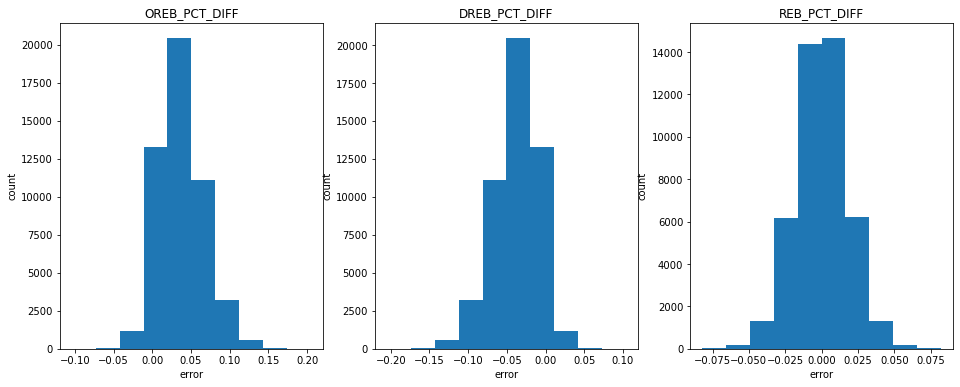

In [8]:
#plot error of calculated rebound percentage stats
fig, axes = plt.subplots(1, 3, figsize=[16, 6])

axes[0].hist(team_boxscores_df['OREB_PCT_CALC_DIFF'])
axes[0].set_title('OREB_PCT_DIFF')
axes[0].set_xlabel('error')
axes[0].set_ylabel('count')

axes[1].hist(team_boxscores_df['DREB_PCT_CALC_DIFF'])
axes[1].set_title('DREB_PCT_DIFF')
axes[1].set_xlabel('error')
axes[1].set_ylabel('count')

axes[2].hist(team_boxscores_df['REB_PCT_CALC_DIFF'])
axes[2].set_title('REB_PCT_DIFF')
axes[2].set_xlabel('error')
axes[2].set_ylabel('count')


In [9]:
#fill in missing rebound percentage stats with calculated values
rebound_pct_cols = ['OREB_PCT', 'DREB_PCT', 'REB_PCT']

for col in rebound_pct_cols:
    team_boxscores_df[col].fillna(value=team_boxscores_df[col + '_CALC'], inplace=True)

team_boxscores_df.drop(columns=['OREB_PCT_CALC_DIFF',
                                'DREB_PCT_CALC_DIFF',
                                'REB_PCT_CALC_DIFF',
                                'OREB_PCT_CALC',
                                'DREB_PCT_CALC',
                                'REB_PCT_CALC'], inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [10]:
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56308 entries, 0 to 56307
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56308 non-null  object 
 1   TEAM_ID       56308 non-null  int64  
 2   GAME_ID       56308 non-null  object 
 3   GAME_DATE     56308 non-null  object 
 4   WL            56308 non-null  object 
 5   MIN           56308 non-null  int64  
 6   FGM           56308 non-null  int64  
 7   FGA           56308 non-null  int64  
 8   FG_PCT        56308 non-null  float64
 9   FG3M          56308 non-null  int64  
 10  FG3A          56308 non-null  int64  
 11  FG3_PCT       56308 non-null  float64
 12  FTM           56308 non-null  int64  
 13  FTA           56308 non-null  int64  
 14  FT_PCT        56308 non-null  float64
 15  OREB          56308 non-null  int64  
 16  DREB          56308 non-null  int64  
 17  REB           56308 non-null  int64  
 18  AST           56308 non-nu

In [11]:
#store actual point spread for each game
game_ids = team_boxscores_df['GAME_ID'].unique()
spreads = np.empty(len(game_ids))

for i, game_id in tqdm(enumerate(game_ids)):
    spread = team_boxscores_df[(team_boxscores_df['GAME_ID']==game_id) &
                               (team_boxscores_df['HOME_TEAM']==True)]['PLUS_MINUS']
    spreads[i] = spread

game_spreads_df = pd.DataFrame(data={'GAME_ID':game_ids, 'SPREAD':spreads})
game_spreads_df.head()

28154it [03:03, 153.36it/s]


,GAME_ID,SPREAD
0,0022100002,-7.0
1,0022100001,23.0
2,0022100003,1.0
3,0022100004,-6.0
4,0022100006,-15.0


In [12]:
#change W/L column to 1's and 0's
team_boxscores_df['WL'] = team_boxscores_df['WL'].map({'W':1, 'L':0})

#convert game date to datetime
team_boxscores_df['GAME_DATE'] = pd.to_datetime(team_boxscores_df['GAME_DATE'])


In [13]:
#elo rating helper functions
#credit to rogerfitz

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team

def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    team_rating += 100
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating


In [14]:
def add_elo_ratings(df):
    df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_TEAM'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    elo_col = np.empty(df.shape[0])
    elo_dict = {}
    cur_season = df.iloc[0]['SEASON']
    
    for i, row in tqdm(df.iterrows()):
        
        if i%2 != 0:
            continue
        
        if row['SEASON'] != cur_season:
            cur_season = row['SEASON']
            elo_dict = {team_id:season_reset(elo) for team_id, elo in elo_dict.items()}
        
        away_row = row
        home_row = df.iloc[i+1]
        
        #check both rows are from same game
        if away_row['GAME_ID'] != home_row['GAME_ID']:
            print('game ids do not match')
            print('home game id: ', home_row['GAME_ID'])
            print('away game id: ', away_row['GAME_ID'])
            print('iteration: ', i)
            break
        
        home_team_id = home_row['TEAM_ID']
        away_team_id = away_row['TEAM_ID']
        
        if home_team_id not in elo_dict:
            elo_dict[home_team_id] = 1300
        if away_team_id not in elo_dict:
            elo_dict[away_team_id] = 1300
        
        home_elo = elo_dict[home_team_id]
        away_elo = elo_dict[away_team_id]

        elo_col[i+1] = home_elo
        elo_col[i] = away_elo
        
        home_pts = home_row['PTS']
        away_pts = away_row['PTS']

        home_elo_update, away_elo_update = elo_update(home_pts, away_pts, home_elo, away_elo)
        
        new_home_elo = home_elo + home_elo_update
        new_away_elo = away_elo + away_elo_update
        
        elo_dict[home_team_id] = new_home_elo
        elo_dict[away_team_id] = new_away_elo
    
    df['ELO'] = elo_col
        
    return df
        
    

In [15]:
#add elo ratings
team_boxscores_df = add_elo_ratings(team_boxscores_df)
team_boxscores_df.head()

56308it [00:09, 5640.33it/s]


,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO
0,2000-01,1610612755,0020000001,2000-10-31,1,240,38,66,0.576,3,8,0.375,22,30,0.733,8,29,37,27,10,5,14,24,101,29,Philadelphia,118.5,114.8,81.3,81.8,37.2,33.0,0.711,1.93,22.5,0.258065,0.646000,0.500,16.432,15.9,0.598,0.638,1.0,0.200,86.88,88.0,73.33,88.0,0.819,False,1300.0
1,2000-01,1610612752,0020000001,2000-10-31,0,240,25,70,0.357,3,11,0.273,19,24,0.792,14,23,37,14,6,4,22,30,72,-29,New York,81.3,81.8,118.5,114.8,-37.2,-33.0,0.560,0.64,12.0,0.354000,0.741935,0.500,24.842,25.0,0.379,0.447,1.0,0.201,86.88,88.0,73.33,88.0,0.181,True,1300.0
2,2000-01,1610612739,0020000002,2000-10-31,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,Cleveland,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302000,0.724000,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,False,1300.0
3,2000-01,1610612751,0020000002,2000-10-31,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,New Jersey,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276000,0.698000,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,True,1300.0
4,2000-01,1610612764,0020000003,2000-10-31,0,240,33,72,0.458,4,7,0.571,16,24,0.667,9,35,44,20,6,1,27,28,86,-11,Washington,85.5,87.8,96.5,99.0,-11.0,-11.2,0.606,0.74,15.4,0.279000,0.755000,0.533,26.850,27.6,0.486,0.521,1.0,0.195,100.54,98.0,81.67,98.0,0.415,False,1300.0


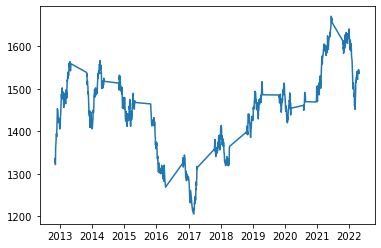

In [16]:
#spot checking to make sure elo ratings make sense
brooklyn_df = team_boxscores_df[team_boxscores_df['TEAM_CITY']=='Brooklyn']
plt.plot(brooklyn_df['GAME_DATE'], brooklyn_df['ELO'])

In [17]:
#calculate win percentage over last n games inplace of WL column
win_pct = np.empty(len(team_boxscores_df))
num_games = 10

for i, row in tqdm(team_boxscores_df.iterrows()):
    team_id = row['TEAM_ID']
    game_date = row['GAME_DATE']
    
    temp_df = team_boxscores_df[(team_boxscores_df['TEAM_ID'] == team_id) &
                               (team_boxscores_df['GAME_DATE'] < game_date)].copy()
    temp_df.sort_values(by=['GAME_DATE'], ascending=True, inplace=True)
    temp_df = temp_df.tail(num_games)
    
    if len(temp_df) < num_games:
        win_pct[i] = 0.5
    else:
        win_pct[i] = np.mean(temp_df['WL'])

team_boxscores_df['RECENT_WIN_PCT'] = win_pct

56308it [03:36, 259.59it/s]


In [18]:
#take exponentially weighted moving average of stats for each game
num_games = 50
alpha = 0.2

exclude_cols = {'SEASON', 
                'TEAM_ID', 
                'GAME_ID', 
                'GAME_DATE', 
                'HOME_TEAM', 
                'TEAM_CITY', 
                'ELO',
                'WL',
                'RECENT_WIN_PCT'}
feature_cols = set(team_boxscores_df.columns) - exclude_cols

weighted_avgs = []

for i, row in tqdm(team_boxscores_df.iterrows()):
    team_id = row['TEAM_ID']
    game_date = row['GAME_DATE']

    temp_df = team_boxscores_df[(team_boxscores_df['TEAM_ID'] == team_id) &
                                (team_boxscores_df['GAME_DATE'] < game_date)].copy()
    temp_df.sort_values(by=['GAME_DATE'], ascending=True, inplace=True)
    temp_df = temp_df.tail(num_games)
    
    #if less than num_games available, continue to next iteration
    if len(temp_df) < num_games:
        continue
    
    temp_df[list(feature_cols)] = temp_df[list(feature_cols)].ewm(alpha=alpha).mean()
    
    row[list(feature_cols)] = temp_df.iloc[-1]
    
    weighted_avgs.append(row)

weighted_avg_df = pd.DataFrame(weighted_avgs)
weighted_avg_df.reset_index(drop=True, inplace=True)

56308it [13:38, 68.76it/s]


In [19]:
weighted_avg_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,RECENT_WIN_PCT
0,2000-01,1610612760,0020000689,2001-02-05,1,241.638423,35.568211,75.276104,0.472863,5.838766,12.570600,0.488460,20.779352,28.822867,0.721813,11.042969,29.443827,40.486796,21.386311,7.993893,3.774686,18.286242,20.122878,97.754540,-3.094401,Seattle,102.579918,104.277813,106.205575,107.601779,-3.615996,-3.321021,0.602595,1.223211,16.629846,0.303830,0.693710,0.503269,19.235373,19.549742,0.511516,0.556332,1.0,0.197895,94.560818,93.148888,77.624575,93.668159,0.472576,True,1321.428336,0.6
1,2000-01,1610612760,0020000704,2001-02-07,0,241.310739,36.254589,76.620877,0.473491,5.671004,13.256460,0.453368,19.023470,27.058288,0.697450,11.434372,29.155033,40.589406,22.309066,8.795134,4.619746,17.628982,19.698282,97.203652,0.124534,Seattle,102.543972,104.082286,103.284449,103.901401,-0.752748,0.163241,0.615476,1.324571,17.243890,0.306864,0.714969,0.507744,18.621090,18.899784,0.510413,0.549666,1.0,0.197716,93.876634,92.919096,77.433648,93.334513,0.492061,False,1325.541563,0.7
2,2000-01,1610612751,0020000706,2001-02-08,1,240.000000,32.957639,80.451293,0.408363,4.175637,13.396140,0.300524,21.724674,28.564942,0.759680,11.390307,27.793369,39.183676,19.166584,8.436780,5.808485,13.567085,26.875460,91.815589,-5.535194,New Jersey,96.324760,97.722001,102.282798,104.110038,-5.990397,-6.366088,0.585554,1.592496,15.162122,0.286390,0.681371,0.469349,14.234707,14.468615,0.433993,0.492393,1.0,0.197767,95.209213,93.651465,78.043074,93.811778,0.438794,True,1158.589256,0.3
3,2000-01,1610612766,0020000707,2001-02-08,1,240.752825,32.035058,78.741623,0.409056,3.865876,11.353456,0.329355,17.955401,24.225710,0.742676,12.493917,29.973376,42.467293,19.219695,7.898043,5.307499,14.748911,20.370887,85.891393,-7.748656,Charlotte,93.827193,93.482316,101.157880,102.004498,-7.333383,-8.531726,0.595488,1.400946,15.467060,0.289743,0.720098,0.499812,16.082623,16.029445,0.433555,0.481879,1.0,0.199538,91.899266,91.661697,76.384765,91.968286,0.447061,True,1299.264022,0.2
4,2000-01,1610612743,0020000708,2001-02-08,0,240.012425,34.919353,80.639455,0.432776,6.602631,18.589659,0.369718,17.399848,22.655137,0.754727,11.883804,32.610388,44.494191,22.960098,5.679325,6.356878,14.892684,21.751957,93.841186,-5.691430,Denver,100.139469,100.501356,105.359802,107.075904,-5.199439,-6.556587,0.652979,1.646223,17.745251,0.291870,0.717225,0.507654,15.936966,15.956996,0.473679,0.516741,1.0,0.198661,94.079266,93.157283,77.630743,93.320402,0.460357,False,1312.520179,0.3


In [20]:
#add number of rest days
rest_days = np.empty(weighted_avg_df.shape[0])

for i, row in tqdm(weighted_avg_df.iterrows()):
    game_date = row['GAME_DATE']
    team_id = row['TEAM_ID']
    rest_days_df = weighted_avg_df[(weighted_avg_df['TEAM_ID'] == team_id) &
                                     (weighted_avg_df['GAME_DATE'] < game_date)].copy()
    if len(rest_days_df) == 0:
        #if no previous games, default rest days to 3
        rest_days[i] = 3
        continue
    
    rest_days_df.sort_values(by=['GAME_DATE'], ascending=False, inplace=True, ignore_index=True)
    last_game_date = rest_days_df.iloc[0]['GAME_DATE']
    
    #to limit high variance in rest days due to off-season and all-star break, set max number of rest days to 3
    delta = min((game_date - last_game_date).days, 3)
    rest_days[i] = delta
    
weighted_avg_df['REST_DAYS'] = rest_days

54808it [03:41, 247.57it/s]


In [21]:
#QA rest days
weighted_avg_df[weighted_avg_df['TEAM_ID']==1610612744].sort_values(by=['GAME_DATE'])

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,RECENT_WIN_PCT,REST_DAYS
37,2000-01,1610612744,0020000741,2001-02-16,0,240.005442,35.000808,88.035910,0.398807,4.429669,14.676029,0.296608,14.804195,21.954107,0.665176,14.752214,31.308895,46.061109,21.787320,9.513677,4.822233,14.822825,20.106209,89.235479,-8.752974,Golden State,91.321889,92.773030,102.026111,101.702698,-10.694018,-8.913752,0.621362,1.547411,16.171352,0.306064,0.744168,0.500265,15.137860,15.392955,0.424691,0.458590,1.0,0.199775,96.972130,96.270286,80.226555,96.184647,0.425669,True,1174.492742,0.2,3.0
63,2000-01,1610612744,0020000756,2001-02-18,0,240.004353,34.600649,86.428731,0.401645,3.743727,14.140834,0.253885,14.243310,20.363217,0.703541,15.001777,30.447076,45.448853,21.829867,9.210933,4.057775,15.858257,19.884959,87.188335,-9.602422,Golden State,90.577494,92.178417,102.020924,102.042195,-11.435266,-9.851046,0.630490,1.457929,16.377092,0.325652,0.754158,0.518020,16.546893,16.854371,0.423553,0.458472,1.0,0.199820,95.609665,94.716184,78.931207,94.547672,0.425135,True,1160.076977,0.2,2.0
78,2000-01,1610612744,0020000765,2001-02-20,0,240.003483,34.480508,88.142985,0.392916,3.994984,14.312676,0.269708,14.994651,21.490568,0.701233,16.601441,31.157658,47.759099,21.263888,8.968749,3.646186,15.886608,20.907956,87.950651,-9.081946,Golden State,90.761996,92.122716,101.236733,101.433748,-10.468206,-9.300845,0.616192,1.404343,15.781670,0.339321,0.757872,0.521963,16.455520,16.723500,0.415642,0.452177,1.0,0.200056,96.423721,95.572948,79.644966,95.438138,0.418308,False,1150.450621,0.1,2.0
108,2000-01,1610612744,0020000780,2001-02-22,0,240.002786,35.984403,89.714362,0.401933,3.795976,13.650127,0.270366,14.995729,22.192463,0.680987,16.681142,30.126129,46.807271,23.011133,9.375005,4.916957,15.109301,20.126350,90.760512,-9.465554,Golden State,92.609585,95.178180,104.849395,105.187007,-12.234586,-10.000679,0.635754,1.623473,16.645350,0.361057,0.722898,0.519371,15.517430,15.898816,0.423114,0.457142,1.0,0.199645,96.806970,95.358342,79.465959,95.350496,0.427646,False,1147.291823,0.1,2.0
126,2000-01,1610612744,0020000789,2001-02-23,0,240.002229,35.987531,89.171513,0.404346,4.036792,12.720116,0.327494,14.796575,20.953945,0.719790,15.344916,29.100869,44.445785,22.808912,9.500018,4.333563,14.287384,19.101072,90.808430,-7.972360,Golden State,93.227727,95.302595,103.439499,103.529578,-10.207593,-8.220464,0.630803,1.698782,16.776289,0.331246,0.714718,0.500896,14.728698,15.039004,0.427091,0.462514,1.0,0.199716,96.457530,95.386638,79.488738,95.280360,0.429917,False,1145.949465,0.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54799,2021-22,1610612744,0042100402,2022-06-05,1,240.000000,41.686570,86.243432,0.485069,14.035846,36.220030,0.387041,15.195056,19.355575,0.787848,10.976189,34.764863,45.741052,28.017672,6.101139,4.491900,13.727524,20.077649,112.604041,1.571320,Golden State,115.774947,116.736635,113.416616,115.929427,2.350749,0.815417,0.670783,2.205131,20.482626,0.297732,0.781830,0.545947,14.005592,14.164508,0.566356,0.595359,1.0,0.197602,97.753233,96.256065,80.213752,96.613328,0.520501,True,1672.682633,0.7,3.0
54800,2021-22,1610612744,0042100403,2022-06-08,0,240.000000,41.149253,86.194712,0.478655,14.228679,36.376002,0.390633,14.956039,19.484466,0.770277,9.980923,35.011882,44.992804,27.414141,7.880931,3.993503,13.382019,19.462102,111.483224,5.057099,Golden State,113.859953,115.449305,108.253241,110.703486,5.600646,4.752387,0.664827,2.180105,20.186107,0.282985,0.781464,0.537758,13.585474,13.811607,

In [22]:
#reformat so each game is represented by a single row
home_df = weighted_avg_df[weighted_avg_df['HOME_TEAM']==True]
away_df = weighted_avg_df[weighted_avg_df['HOME_TEAM']==False]

boxscore_df = home_df.merge(away_df, on='GAME_ID', how='inner', suffixes=('_HOME', '_AWAY'))
boxscore_df.head()

,SEASON_HOME,TEAM_ID_HOME,GAME_ID,GAME_DATE_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,HOME_TEAM_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,SEASON_AWAY,TEAM_ID_AWAY,GAME_DATE_AWAY,WL_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,HOME_TEAM_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY
0,2000-01,1610612748,0020000711,2001-02-13,1,246.662597,34.451863,76.768852,0.447277,6.175341,16.542049,0.383801,20.374131,26.422705,0.761088,10.290529,31.694234,41.984763,19.707167,7.059175,3.579154,12.833728,21.075995,95.453198,7.937535,Miami,105.106674,105.346787,95.640856,97.237451,9.439319,8.115591,0.577017,1.640529,16.265862,0.277236,0.728099,0.508695,14.099631,14.115769,0.487582,0.539441,1.0,0.198941,88.858375,88.034877,73.362497,90.782654,0.573720,True,1396.531075,0.7,3.0,2000-01,1610612746,2001-02-13,0,241.140771,36.634459,79.979298,0.459276,3.887935,12.105099,0.317068,12.633248,19.439136,0.661269,11.810697,31.878287,43.688983,19.363701,6.099861,7.077672,14.555197,20.534054,89.790100,-0.920506,Los Angeles,98.427469,101.603505,101.462101,102.376230,-3.028228,-0.779455,0.531096,1.465191,15.789589,0.311352,0.675521,0.499227,15.850399,16.360438,0.483223,0.508449,1.0,0.197281,89.936962,88.113577,73.429263,88.446528,0.480384,False,1208.524359,0.3,3.0
1,2000-01,1610612757,0020000721,2001-02-13,1,240.058685,36.214069,78.419419,0.462757,3.946683,10.331961,0.389457,15.998141,21.506385,0.727501,12.949235,29.576623,42.525857,21.739621,7.951678,4.353183,14.680237,17.805262,92.372961,5.067110,Portland,102.782824,103.347194,97.596596,98.165472,5.190372,5.172764,0.604021,1.522502,17.399633,0.337736,0.705180,0.524568,16.308396,16.385076,0.488027,0.526187,1.0,0.198709,89.574653,89.099407,74.249987,89.293112,0.539134,True,1413.853474,0.6,3.0,2000-01,1610612750,2001-02-13,0,240.023599,40.389552,81.296254,0.495293,4.213676,11.131319,0.353903,16.541180,20.074247,0.838625,10.803945,32.001991,42.805937,28.810678,7.806221,7.190502,14.894458,23.807853,101.533960,11.012171,Minnesota,107.747813,109.397495,96.594638,97.843824,11.133798,11.548808,0.712120,2.003189,21.384272,0.289468,0.685915,0.512137,15.764265,16.008307,0.521141,0.563510,1.0,0.198599,93.973435,92.691956,77.242858,92.784985,0.585670,False,1385.270634,1.0,3.0
2,2000-01,1610612765,0020000726,2001-02-14,1,243.257693,35.394704,86.100697,0.413552,4.700943,12.759204,0.358062,18.253543,24.882276,0.737917,14.145118,31.007257,45.152375,19.182920,7.345001,4.177185,14.852036,22.170893,93.743894,-3.037921,Detroit,95.995270,98.502868,101.725005,101.755875,-5.736148,-3.258012,0.539743,1.374245,14.583542,0.342754,0.743329,0.518823,15.126043,15.564555,0.441244,0.484738,1.0,0.198566,95.296118,93.943498,78.286510,95.154644,0.463968,True,1194.196873,0.4,3.0,2000-01,1610612751,2001-02-14,0,245.000071,34.332913,80.968829,0.422913,5.392437,13.893571,0.379817,22.543804,29.481555,0.764196,11.089783,28.427739,39.517523,19.186606,8.199524,4.237405,13.242925,27.280288,96.602067,-3.822548,New Jersey,100.391936,102.390182,104.

In [23]:
#create lookup for team id and team city
team_id_city_lookup = {}
for i, row in boxscore_df.iterrows():
    team_id = row['TEAM_ID_HOME']
    team_city = row['TEAM_CITY_HOME']
    if team_id not in team_id_city_lookup:
        team_id_city_lookup[team_id] = [team_city]
    elif team_city not in team_id_city_lookup[team_id]:
        team_id_city_lookup[team_id].append(team_city)
team_id_city_lookup

{1610612748: ['Miami'],
 1610612757: ['Portland'],
 1610612765: ['Detroit'],
 1610612761: ['Toronto'],
 1610612760: ['Seattle', 'Oklahoma City'],
 1610612755: ['Philadelphia'],
 1610612744: ['Golden State'],
 1610612742: ['Dallas'],
 1610612751: ['New Jersey', 'Brooklyn'],
 1610612753: ['Orlando'],
 1610612754: ['Indiana'],
 1610612750: ['Minnesota'],
 1610612743: ['Denver'],
 1610612739: ['Cleveland'],
 1610612749: ['Milwaukee'],
 1610612762: ['Utah'],
 1610612752: ['New York'],
 1610612764: ['Washington'],
 1610612741: ['Chicago'],
 1610612745: ['Houston'],
 1610612758: ['Sacramento'],
 1610612759: ['San Antonio'],
 1610612766: ['Charlotte'],
 1610612747: ['Los Angeles'],
 1610612746: ['Los Angeles', 'LA'],
 1610612756: ['Phoenix'],
 1610612738: ['Boston'],
 1610612763: ['Vancouver', 'Memphis'],
 1610612737: ['Atlanta'],
 1610612740: ['New Orleans', 'New Orleans/Oklahoma City']}

In [24]:
print(list(boxscore_df.columns))

['SEASON_HOME', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE_HOME', 'WL_HOME', 'MIN_HOME', 'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME', 'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME', 'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME', 'REB_HOME', 'AST_HOME', 'STL_HOME', 'BLK_HOME', 'TOV_HOME', 'PF_HOME', 'PTS_HOME', 'PLUS_MINUS_HOME', 'TEAM_CITY_HOME', 'E_OFF_RATING_HOME', 'OFF_RATING_HOME', 'E_DEF_RATING_HOME', 'DEF_RATING_HOME', 'E_NET_RATING_HOME', 'NET_RATING_HOME', 'AST_PCT_HOME', 'AST_TOV_HOME', 'AST_RATIO_HOME', 'OREB_PCT_HOME', 'DREB_PCT_HOME', 'REB_PCT_HOME', 'E_TM_TOV_PCT_HOME', 'TM_TOV_PCT_HOME', 'EFG_PCT_HOME', 'TS_PCT_HOME', 'USG_PCT_HOME', 'E_USG_PCT_HOME', 'E_PACE_HOME', 'PACE_HOME', 'PACE_PER40_HOME', 'POSS_HOME', 'PIE_HOME', 'HOME_TEAM_HOME', 'ELO_HOME', 'RECENT_WIN_PCT_HOME', 'REST_DAYS_HOME', 'SEASON_AWAY', 'TEAM_ID_AWAY', 'GAME_DATE_AWAY', 'WL_AWAY', 'MIN_AWAY', 'FGM_AWAY', 'FGA_AWAY', 'FG_PCT_AWAY', 'FG3M_AWAY', 'FG3A_AWAY', 'FG3_PCT_AWAY', 'FTM_AWAY', 'FTA_AWAY', 'FT_P

In [25]:
#drop unnecessary columns
boxscore_df.drop(columns=['SEASON_AWAY',
                          'GAME_DATE_AWAY',
                          'WL_AWAY',
                          'WL_HOME',
                          'HOME_TEAM_HOME',
                          'HOME_TEAM_AWAY'], inplace=True)
boxscore_df.head()

,SEASON_HOME,TEAM_ID_HOME,GAME_ID,GAME_DATE_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY
0,2000-01,1610612748,0020000711,2001-02-13,246.662597,34.451863,76.768852,0.447277,6.175341,16.542049,0.383801,20.374131,26.422705,0.761088,10.290529,31.694234,41.984763,19.707167,7.059175,3.579154,12.833728,21.075995,95.453198,7.937535,Miami,105.106674,105.346787,95.640856,97.237451,9.439319,8.115591,0.577017,1.640529,16.265862,0.277236,0.728099,0.508695,14.099631,14.115769,0.487582,0.539441,1.0,0.198941,88.858375,88.034877,73.362497,90.782654,0.573720,1396.531075,0.7,3.0,1610612746,241.140771,36.634459,79.979298,0.459276,3.887935,12.105099,0.317068,12.633248,19.439136,0.661269,11.810697,31.878287,43.688983,19.363701,6.099861,7.077672,14.555197,20.534054,89.790100,-0.920506,Los Angeles,98.427469,101.603505,101.462101,102.376230,-3.028228,-0.779455,0.531096,1.465191,15.789589,0.311352,0.675521,0.499227,15.850399,16.360438,0.483223,0.508449,1.0,0.197281,89.936962,88.113577,73.429263,88.446528,0.480384,1208.524359,0.3,3.0
1,2000-01,1610612757,0020000721,2001-02-13,240.058685,36.214069,78.419419,0.462757,3.946683,10.331961,0.389457,15.998141,21.506385,0.727501,12.949235,29.576623,42.525857,21.739621,7.951678,4.353183,14.680237,17.805262,92.372961,5.067110,Portland,102.782824,103.347194,97.596596,98.165472,5.190372,5.172764,0.604021,1.522502,17.399633,0.337736,0.705180,0.524568,16.308396,16.385076,0.488027,0.526187,1.0,0.198709,89.574653,89.099407,74.249987,89.293112,0.539134,1413.853474,0.6,3.0,1610612750,240.023599,40.389552,81.296254,0.495293,4.213676,11.131319,0.353903,16.541180,20.074247,0.838625,10.803945,32.001991,42.805937,28.810678,7.806221,7.190502,14.894458,23.807853,101.533960,11.012171,Minnesota,107.747813,109.397495,96.594638,97.843824,11.133798,11.548808,0.712120,2.003189,21.384272,0.289468,0.685915,0.512137,15.764265,16.008307,0.521141,0.563510,1.0,0.198599,93.973435,92.691956,77.242858,92.784985,0.585670,1385.270634,1.0,3.0
2,2000-01,1610612765,0020000726,2001-02-14,243.257693,35.394704,86.100697,0.413552,4.700943,12.759204,0.358062,18.253543,24.882276,0.737917,14.145118,31.007257,45.152375,19.182920,7.345001,4.177185,14.852036,22.170893,93.743894,-3.037921,Detroit,95.995270,98.502868,101.725005,101.755875,-5.736148,-3.258012,0.539743,1.374245,14.583542,0.342754,0.743329,0.518823,15.126043,15.564555,0.441244,0.484738,1.0,0.198566,95.296118,93.943498,78.286510,95.154644,0.463968,1194.196873,0.4,3.0,1610612751,245.000071,34.332913,80.968829,0.422913,5.392437,13.893571,0.379817,22.543804,29.481555,0.764196,11.089783,28.427739,39.517523,19.186606,8.199524,4.237405,13.242925,27.280288,96.602067,-3.822548,New Jersey,100.391936,102.390182,104.873115,106.094543,-4.517888,-3.690314,0.562354,1.567198,15.131755,0.284089,0.652597,0.462503,13.762162,14.055905,0.455916,0.513012,1.0,0.196891,93.986266,92.508906,77.09

In [26]:
#add actual point spreads back to boxscore data
final_df = boxscore_df.merge(game_spreads_df, on='GAME_ID', how='inner')
final_df.rename(columns={'SPREAD':'GAME_SPREAD', 'SEASON_HOME':'SEASON', 'GAME_DATE_HOME':'GAME_DATE'}, inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,2000-01,1610612748,0020000711,2001-02-13,246.662597,34.451863,76.768852,0.447277,6.175341,16.542049,0.383801,20.374131,26.422705,0.761088,10.290529,31.694234,41.984763,19.707167,7.059175,3.579154,12.833728,21.075995,95.453198,7.937535,Miami,105.106674,105.346787,95.640856,97.237451,9.439319,8.115591,0.577017,1.640529,16.265862,0.277236,0.728099,0.508695,14.099631,14.115769,0.487582,0.539441,1.0,0.198941,88.858375,88.034877,73.362497,90.782654,0.573720,1396.531075,0.7,3.0,1610612746,241.140771,36.634459,79.979298,0.459276,3.887935,12.105099,0.317068,12.633248,19.439136,0.661269,11.810697,31.878287,43.688983,19.363701,6.099861,7.077672,14.555197,20.534054,89.790100,-0.920506,Los Angeles,98.427469,101.603505,101.462101,102.376230,-3.028228,-0.779455,0.531096,1.465191,15.789589,0.311352,0.675521,0.499227,15.850399,16.360438,0.483223,0.508449,1.0,0.197281,89.936962,88.113577,73.429263,88.446528,0.480384,1208.524359,0.3,3.0,2.0
1,2000-01,1610612757,0020000721,2001-02-13,240.058685,36.214069,78.419419,0.462757,3.946683,10.331961,0.389457,15.998141,21.506385,0.727501,12.949235,29.576623,42.525857,21.739621,7.951678,4.353183,14.680237,17.805262,92.372961,5.067110,Portland,102.782824,103.347194,97.596596,98.165472,5.190372,5.172764,0.604021,1.522502,17.399633,0.337736,0.705180,0.524568,16.308396,16.385076,0.488027,0.526187,1.0,0.198709,89.574653,89.099407,74.249987,89.293112,0.539134,1413.853474,0.6,3.0,1610612750,240.023599,40.389552,81.296254,0.495293,4.213676,11.131319,0.353903,16.541180,20.074247,0.838625,10.803945,32.001991,42.805937,28.810678,7.806221,7.190502,14.894458,23.807853,101.533960,11.012171,Minnesota,107.747813,109.397495,96.594638,97.843824,11.133798,11.548808,0.712120,2.003189,21.384272,0.289468,0.685915,0.512137,15.764265,16.008307,0.521141,0.563510,1.0,0.198599,93.973435,92.691956,77.242858,92.784985,0.585670,1385.270634,1.0,3.0,21.0
2,2000-01,1610612765,0020000726,2001-02-14,243.257693,35.394704,86.100697,0.413552,4.700943,12.759204,0.358062,18.253543,24.882276,0.737917,14.145118,31.007257,45.152375,19.182920,7.345001,4.177185,14.852036,22.170893,93.743894,-3.037921,Detroit,95.995270,98.502868,101.725005,101.755875,-5.736148,-3.258012,0.539743,1.374245,14.583542,0.342754,0.743329,0.518823,15.126043,15.564555,0.441244,0.484738,1.0,0.198566,95.296118,93.943498,78.286510,95.154644,0.463968,1194.196873,0.4,3.0,1610612751,245.000071,34.332913,80.968829,0.422913,5.392437,13.893571,0.379817,22.543804,29.481555,0.764196,11.089783,28.427739,39.517523,19.186606,8.199524,4.237405,13.242925,27.280288,96.602067,-3.822548,New Jersey,100.391936,102.390182,104.873115,106.094543,-4.517888,-3.690314,0.562354,1.567198,15.131755,0.284089,0.652597,0.462503,13.762162,14.055905,0.455916,0.513012,1.0,0.196891,93.986266,92.5

In [27]:
#drop unneeded columns
final_df.drop(columns=['USG_PCT_HOME',
                      'E_USG_PCT_HOME',
                      'USG_PCT_AWAY',
                      'E_USG_PCT_AWAY',
                      'MIN_HOME',
                      'MIN_AWAY'], inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,2000-01,1610612748,0020000711,2001-02-13,34.451863,76.768852,0.447277,6.175341,16.542049,0.383801,20.374131,26.422705,0.761088,10.290529,31.694234,41.984763,19.707167,7.059175,3.579154,12.833728,21.075995,95.453198,7.937535,Miami,105.106674,105.346787,95.640856,97.237451,9.439319,8.115591,0.577017,1.640529,16.265862,0.277236,0.728099,0.508695,14.099631,14.115769,0.487582,0.539441,88.858375,88.034877,73.362497,90.782654,0.573720,1396.531075,0.7,3.0,1610612746,36.634459,79.979298,0.459276,3.887935,12.105099,0.317068,12.633248,19.439136,0.661269,11.810697,31.878287,43.688983,19.363701,6.099861,7.077672,14.555197,20.534054,89.790100,-0.920506,Los Angeles,98.427469,101.603505,101.462101,102.376230,-3.028228,-0.779455,0.531096,1.465191,15.789589,0.311352,0.675521,0.499227,15.850399,16.360438,0.483223,0.508449,89.936962,88.113577,73.429263,88.446528,0.480384,1208.524359,0.3,3.0,2.0
1,2000-01,1610612757,0020000721,2001-02-13,36.214069,78.419419,0.462757,3.946683,10.331961,0.389457,15.998141,21.506385,0.727501,12.949235,29.576623,42.525857,21.739621,7.951678,4.353183,14.680237,17.805262,92.372961,5.067110,Portland,102.782824,103.347194,97.596596,98.165472,5.190372,5.172764,0.604021,1.522502,17.399633,0.337736,0.705180,0.524568,16.308396,16.385076,0.488027,0.526187,89.574653,89.099407,74.249987,89.293112,0.539134,1413.853474,0.6,3.0,1610612750,40.389552,81.296254,0.495293,4.213676,11.131319,0.353903,16.541180,20.074247,0.838625,10.803945,32.001991,42.805937,28.810678,7.806221,7.190502,14.894458,23.807853,101.533960,11.012171,Minnesota,107.747813,109.397495,96.594638,97.843824,11.133798,11.548808,0.712120,2.003189,21.384272,0.289468,0.685915,0.512137,15.764265,16.008307,0.521141,0.563510,93.973435,92.691956,77.242858,92.784985,0.585670,1385.270634,1.0,3.0,21.0
2,2000-01,1610612765,0020000726,2001-02-14,35.394704,86.100697,0.413552,4.700943,12.759204,0.358062,18.253543,24.882276,0.737917,14.145118,31.007257,45.152375,19.182920,7.345001,4.177185,14.852036,22.170893,93.743894,-3.037921,Detroit,95.995270,98.502868,101.725005,101.755875,-5.736148,-3.258012,0.539743,1.374245,14.583542,0.342754,0.743329,0.518823,15.126043,15.564555,0.441244,0.484738,95.296118,93.943498,78.286510,95.154644,0.463968,1194.196873,0.4,3.0,1610612751,34.332913,80.968829,0.422913,5.392437,13.893571,0.379817,22.543804,29.481555,0.764196,11.089783,28.427739,39.517523,19.186606,8.199524,4.237405,13.242925,27.280288,96.602067,-3.822548,New Jersey,100.391936,102.390182,104.873115,106.094543,-4.517888,-3.690314,0.562354,1.567198,15.131755,0.284089,0.652597,0.462503,13.762162,14.055905,0.455916,0.513012,93.986266,92.508906,77.091541,94.199531,0.452148,1162.723408,0.3,1.0,19.0
3,2000-01,1610612761,0020000729,2001-02-15,38.337142,83.708173,0.458857,5.563369,13.628230,0.413271,22.217298,28.669690,0.768822,12.764038,30.067086,42.831124

In [28]:
final_df.describe()

,TEAM_ID_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
count,2.736500e+04,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,2.736500e+04,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000
mean,1.610613e+09,37.616685,82.910651,0.454595,7.798623,21.882970,0.353105,18.110201,23.846200,0.760093,10.934575,31.684674,42.619249,22.077616,7.549919,4.876195,14.334688,20.932418,101.142194,-0.077781,104.471303,106.094176,104.546987,106.175692,-0.075593,-0.081542,0.586008,1.686828,16.905458,0.288314,0.711162,0.499720,14.803623,15.043006,0.501334,0.542156,96.101530,94.590409,78.825336,95.279699,0.499433,1481.445438,0.498308,2.115586,1.610613e+09,37.671211,82.977268,0.454861,7.802088,21.863814,0.353459,18.141736,23.887239,0.760124,10.970471,31.722768,42.693238,22.123395,7.563778,4.888035,14.325690,20.907622,101.286247,0.099280,104.574316,106.202105,104.477375,106.098755,0.096846,0.103390,0.586378,1.692115,16.924165,0.289058,0.711536,0.500337,14.788553,15.028063,0.501585,0.542415,96.136102,94.625519,78.854591,95.315928,0.500694,1481.036127,0.502500,1.917047,2.935136
std,8.616911e+00,2.916904,4.637208,0.023977,3.056856,8.006152,0.041278,2.784103,3.569493,0.044083,1.846739,2.802715,2.959271,2.734341,1.263196,1.151225,1.707593,2.194214,7.987643,6.135783,5.606052,5.599078,5.374935,5.367433,6.685678,6.378470,0.052369,0.330837,1.616225,0.037264,0.032442,0.021072,1.780775,1.817024,0.032962,0.030027,4.250935,4.112753,3.427284,4.179205,0.044694,133.783084,0.206421,0.620079,8.617047e+00,2.937157,4.629463,0.024033,3.060775,7.986789,0.041109,2.784367,3.578976,0.043715,1.859142,2.790738,2.963532,2.740628,1.265175,1.153005,1.717543,2.181177,8.022204,6.132184,5.645914,5.634658,5.412471,5.400658,6.681867,6.375899,0.052297,0.336701,1.617009,0.037410,0.032373,0.021139,1.786468,1.823817,0.033084,0.030104,4.227237,4.092120,3.410086,4.160030,0.044638,133.488795,0.205774,0.686168,13.399945
min,1.610613e+09,27.455303,68.9

array([[<AxesSubplot:title={'center':'TEAM_ID_HOME'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'FGM_HOME'}>,
        <AxesSubplot:title={'center':'FGA_HOME'}>,
        <AxesSubplot:title={'center':'FG_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FG3M_HOME'}>,
        <AxesSubplot:title={'center':'FG3A_HOME'}>,
        <AxesSubplot:title={'center':'FG3_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FTM_HOME'}>],
       [<AxesSubplot:title={'center':'FTA_HOME'}>,
        <AxesSubplot:title={'center':'FT_PCT_HOME'}>,
        <AxesSubplot:title={'center':'OREB_HOME'}>,
        <AxesSubplot:title={'center':'DREB_HOME'}>,
        <AxesSubplot:title={'center':'REB_HOME'}>,
        <AxesSubplot:title={'center':'AST_HOME'}>,
        <AxesSubplot:title={'center':'STL_HOME'}>,
        <AxesSubplot:title={'center':'BLK_HOME'}>,
        <AxesSubplot:title={'center':'TOV_HOME'}>],
       [<AxesSubplot:title={'center':'PF_HOME'}>,
        <Ax

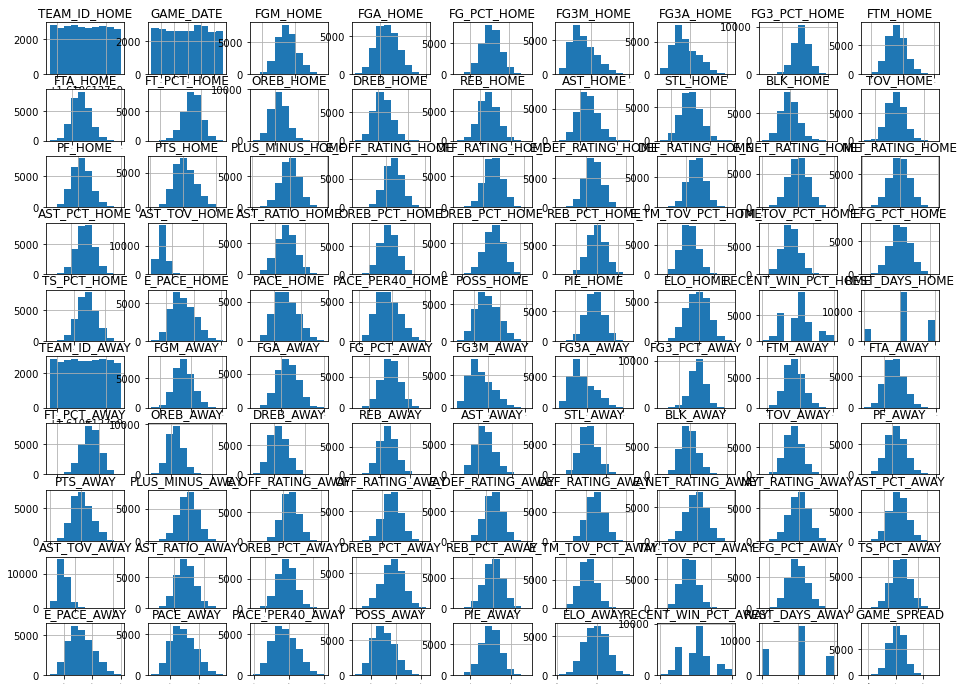

In [29]:
#check distribution of data
final_df.hist(figsize=(16,12), xlabelsize=0)

In [30]:
def check_missing_vals(df):
    cols_w_missing_vals = []
    for col in df.columns:
        if df[col].isna().sum() != 0:
            cols_w_missing_vals.append(col)
    return cols_w_missing_vals

In [31]:
check_missing_vals(final_df)

[]

In [32]:
final_df.to_csv('data_alpha_{}_games_{}.csv'.format(alpha, num_games))
print('Data converted to csv')
print('Runtime : ', datetime.now() - start_time)

Data converted to csv
Runtime :  0:31:50.522292


## IGNORE BELOW

In [27]:
#import betting spreads data
book_spreads_df = pd.read_csv('spreads_df.csv')
book_spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
book_spreads_df.head()

,GM_DATE,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2021-10-19,Milwaukee,+1½,-110,+2,-113,+2,-113,+2½,-135,-1½,-110,-2,-108,-2,-108,-2½,-105
1,2021-10-19,L.A. Lakers,+3,-110,+3,-112,+3,-112,+4,-135,-3,-110,-3,-109,-3,-109,-4,-105
2,2021-10-20,Charlotte,-1,+100,+½,-110,+1½,-110,-1½,-110,+1,-120,-½,-110,-1½,-112,+1½,-110
3,2021-10-20,Detroit,-5,-110,-5,-112,-5,-112,-5,-110,+5,-110,+5,-110,+5,-110,+5,-110
4,2021-10-20,Toronto,+2½,-110,+2½,-109,+3,-109,+4½,-160,-2½,-110,-2½,-112,-3,-112,-4½,+115


In [28]:
#clean up lookup table to align team ids with team city names from sportsbooks
team_id_city_lookup[1610612747] = ['L.A. Lakers']
team_id_city_lookup[1610612746] = ['L.A. Clippers']
team_id_city_lookup[1610612760] = ['Oklahoma City']
team_id_city_lookup[1610612751] = ['Brooklyn']
team_id_city_lookup[1610612763] = ['Memphis']
team_id_city_lookup[1610612740] = ['New Orleans']

team_city_id_lookup = {}

for key, val in team_id_city_lookup.items():
    team_city_id_lookup[val[0]] = key

team_city_id_lookup

{'Miami': 1610612748,
 'Portland': 1610612757,
 'Detroit': 1610612765,
 'Toronto': 1610612761,
 'Oklahoma City': 1610612760,
 'Philadelphia': 1610612755,
 'Golden State': 1610612744,
 'Dallas': 1610612742,
 'Brooklyn': 1610612751,
 'Orlando': 1610612753,
 'Indiana': 1610612754,
 'Minnesota': 1610612750,
 'Denver': 1610612743,
 'Cleveland': 1610612739,
 'Milwaukee': 1610612749,
 'Utah': 1610612762,
 'New York': 1610612752,
 'Washington': 1610612764,
 'Chicago': 1610612741,
 'Houston': 1610612745,
 'Sacramento': 1610612758,
 'San Antonio': 1610612759,
 'Charlotte': 1610612766,
 'L.A. Lakers': 1610612747,
 'L.A. Clippers': 1610612746,
 'Phoenix': 1610612756,
 'Boston': 1610612738,
 'Memphis': 1610612763,
 'Atlanta': 1610612737,
 'New Orleans': 1610612740}

In [29]:
#add team ids to sportsbook df
book_spreads_df['TEAM_ID_HOME'] = book_spreads_df.apply(lambda row: team_city_id_lookup[row['HOME_TEAM']], axis=1)

#merge boxscores and sportsbook data
book_spreads_df.rename(columns={'GM_DATE':'GAME_DATE'}, inplace=True)
final_df['GAME_DATE'] = pd.to_datetime(final_df['GAME_DATE'])
book_spreads_df['GAME_DATE'] = pd.to_datetime(book_spreads_df['GAME_DATE'])
final_df = final_df.merge(book_spreads_df, on=['GAME_DATE', 'TEAM_ID_HOME'], how='inner')
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2017-18,1610612739,0021700001,2017-10-17,241.907707,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,1.0,0.198253,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,240.759964,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,1.0,0.198234,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-
1,2017-18,1610612744,0021700002,2017-10-17,240.166179,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,1.0,0.199145,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,241.327532,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,1.0,0.197685,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-
2,2017-18,1610612765,0021700003,2017-10-18,242.238491,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,1.0,0.198540,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,1610612766,241.466616,37.551128,84.559453,0.445145,10.181026,29.476365,0.340145,19.005851,22.6

In [30]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [31]:
#add target variables for each book

book_1_target = np.empty(len(final_df))
book_2_target = np.empty(len(final_df))
book_3_target = np.empty(len(final_df))
book_4_target = np.empty(len(final_df))

for i, row in tqdm(final_df.iterrows()):
    actual_spread = row['GAME_SPREAD']
    book_1_spread = convert_to_float(row['SPREAD_1_AWAY'])
    book_2_spread = convert_to_float(row['SPREAD_2_AWAY'])
    book_3_spread = convert_to_float(row['SPREAD_3_AWAY'])
    book_4_spread = convert_to_float(row['SPREAD_4_AWAY'])
    
    #target value of -1 means bet on home team loses, 1 means bet on home team wins, 0 means push
    if actual_spread < book_1_spread:
        book_1_target[i] = -1
    elif actual_spread > book_1_spread:
        book_1_target[i] = 1
    elif np.isnan(book_1_spread):
        book_1_target[i] = None
    else:
        book_1_target[i] = 0
        
    if actual_spread < book_2_spread:
        book_2_target[i] = -1
    elif actual_spread > book_2_spread:
        book_2_target[i] = 1
    elif np.isnan(book_2_spread):
        book_2_target[i] = None
    else:
        book_2_target[i] = 0
        
    if actual_spread < book_3_spread:
        book_3_target[i] = -1
    elif actual_spread > book_3_spread:
        book_3_target[i] = 1
    elif np.isnan(book_3_spread):
        book_3_target[i] = None
    else:
        book_3_target[i] = 0
    
    if actual_spread < book_4_spread:
        book_4_target[i] = -1
    elif actual_spread > book_4_spread:
        book_4_target[i] = 1
    elif np.isnan(book_4_spread):
        book_4_target[i] = None
    else:
        book_4_target[i] = 0

final_df['TARGET_BOOK_1'] = book_1_target
final_df['TARGET_BOOK_2'] = book_2_target
final_df['TARGET_BOOK_3'] = book_3_target
final_df['TARGET_BOOK_4'] = book_4_target

final_df.head()

6235it [00:00, 8661.25it/s]


,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
0,2017-18,1610612739,0021700001,2017-10-17,241.907707,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,1.0,0.198253,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,240.759964,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,1.0,0.198234,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
1,2017-18,1610612744,0021700002,2017-10-17,240.166179,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,1.0,0.199145,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,241.327532,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,1.0,0.197685,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
2,2017-18,1610612765,0021700003,2017-10-18,242.238491,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,1.0,0.198540,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,16

In [32]:
final_df.describe()

,TEAM_ID_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
count,6.235000e+03,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.0,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6.235000e+03,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.0,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,5937.000000,2099.000000,569.000000,1197.000000
mean,1.610613e+09,241.513466,40.456697,87.826561,0.461560,11.701189,32.664298,0.357723,17.253687,22.348416,0.772414,10.023239,34.328513,44.351752,24.092774,7.608942,4.828915,14.041287,20.160735,109.868271,-0.003813,108.122424,109.964413,108.120240,109.965370,0.002249,-0.000959,0.595204,1.882201,17.660610,0.266649,0.733189,0.499898,13.788521,14.030732,0.528413,0.563618,1.0,0.198215,101.049276,99.321889,82.768237,99.940630,0.499954,1514.375319,0.498027,2.100080,1.610613e+09,241.511134,40.488183,87.841553,0.461820,11.692469,32.622014,0.357915,17.257383,22.354052,0.772416,10.031412,34.338391,44.369803,24.113463,7.607499,4.832382,14.037783,20.148323,109.926218,0.050435,108.170481,110.017930,108.129224,109.967173,0.041215,0.050805,0.595230,1.884455,17.670499,0.266997,0.733452,0.500222,13.784726,14.027325,0.528610,0.563792,1.0,0.198215,101.050725,99.324363,82.770297,99.942282,0.500277,1514.305485,0.502342,2.013472,2.068645,-0.014317,-0.004288,-0.026362,-0.024227
std,8.614214e+00,1.164092,1.753074,2.515294,0.015687,1.787748,4.639275,0.017916,1.726791,2.197161,0.030631,1.116733,1.737948,2.095707,2.090243,0.826628,0.751717,1.182726,1.468372,4.672497,4.850934,3.802075,3.759341,3.264544,3.243413,4.987032,4.787979,0.040468,0.233089,1.214245,0.021699,0.016882,0.014222,1.069567,1.094324,0.019321,0.019068,0.0,0.000452,2.403030,2.329573,1.941295,2.406512,0.029064,122.580121,0.204405,0.593726,8.615772e+00,1.163743,1.768462,2.503628,0.015714,1.795700,4.654957,0.017839,1.703983,2.174740,0.030469,1.125314,1.743257,2.112489,2.085227,0.832485,0.748097,1.184400,1.454483,4.6

In [33]:
#drop unneeded columns
final_df.drop(columns=['USG_PCT_HOME',
                      'E_USG_PCT_HOME',
                      'USG_PCT_AWAY',
                      'E_USG_PCT_AWAY',
                      'MIN_HOME',
                      'MIN_AWAY'], inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
0,2017-18,1610612739,0021700001,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
1,2017-18,1610612744,0021700002,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
2,2017-18,1610612765,0021700003,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,1610612766,37.551128,84.559453,0.445145,10.181026,29.476365,0.340145,19.005851,22.671633,0.832457,8.353802,32.668577,41.022379,22.462937,7.583587,4.385486,10.649540,15.905752,104.289134,-1.786559,

In [40]:
#filter to only include rows with available betting information for book 1
final_df = final_df[final_df['TARGET_BOOK_1'].notnull()]

In [41]:
final_df.describe()

,TEAM_ID_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
count,5.937000e+03,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5.937000e+03,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,2086.000000,563.000000,1163.000000
mean,1.610613e+09,40.472513,87.843191,0.461657,11.712544,32.683142,0.357830,17.280870,22.379421,0.772506,10.021501,34.339225,44.360726,24.097852,7.609171,4.827652,14.049065,20.189739,109.938439,0.013460,108.149971,109.990554,108.129028,109.974557,0.020977,0.016007,0.595114,1.882146,17.658935,0.266579,0.733273,0.499928,13.790577,14.032466,0.528563,0.563809,101.090921,99.363683,82.803063,99.981454,0.500049,1515.034298,0.498417,2.103756,1.610613e+09,40.505550,87.865947,0.461888,11.704006,32.648548,0.357939,17.294715,22.403213,0.772321,10.037090,34.347607,44.384697,24.121869,7.609032,4.834308,14.049746,20.180377,110.009821,0.075528,108.197233,110.046586,108.132919,109.971069,0.064301,0.075547,0.595208,1.883920,17.668290,0.267091,0.733474,0.500281,13.789448,14.032251,0.528725,0.563957,101.098900,99.370932,82.809104,99.992362,0.500407,1514.945978,0.503150,2.013980,2.149570,-0.014317,-0.004794,-0.026643,-0.028375
std,8.607219e+00,1.756021,2.516332,0.015669,1.791359,4.637356,0.017958,1.728388,2.196923,0.030820,1.118039,1.751988,2.112877,2.099657,0.829835,0.749885,1.184623,1.465858,4.683267,4.839082,3.802230,3.760851,3.261343,3.241984,4.967768,4.774377,0.040626,0.234190,1.219427,0.021782,0.016930,0.014344,1.069704,1.094539,0.019356,0.019080,2.419393,2.345125,1.954256,2.424180,0.028973,122.196735,0.203848,0.595650,8.606768e+00,1.769870,2.514205,0.015616,1.803028,4.666002,0.017815,1.700175,2.165299,0.030487,1.126185,1.754392,2.125919,2.084837,0.833282,0.744632,1.186120,1.455462,4.696442,4.861074,3.811257,3.772666,3.290630,3.270268,4.982220,4.797454,0.040228,0.236374,1.210399,0.021925,0.016878,0.014366,1.074861,1.099859,0.019212,0.018923,2.396190,2.316914,1.930744,2.389752,0.029033,121.562724,0.

array([[<AxesSubplot:title={'center':'TEAM_ID_HOME'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'FGM_HOME'}>,
        <AxesSubplot:title={'center':'FGA_HOME'}>,
        <AxesSubplot:title={'center':'FG_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FG3M_HOME'}>,
        <AxesSubplot:title={'center':'FG3A_HOME'}>,
        <AxesSubplot:title={'center':'FG3_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FTM_HOME'}>,
        <AxesSubplot:title={'center':'FTA_HOME'}>],
       [<AxesSubplot:title={'center':'FT_PCT_HOME'}>,
        <AxesSubplot:title={'center':'OREB_HOME'}>,
        <AxesSubplot:title={'center':'DREB_HOME'}>,
        <AxesSubplot:title={'center':'REB_HOME'}>,
        <AxesSubplot:title={'center':'AST_HOME'}>,
        <AxesSubplot:title={'center':'STL_HOME'}>,
        <AxesSubplot:title={'center':'BLK_HOME'}>,
        <AxesSubplot:title={'center':'TOV_HOME'}>,
        <AxesSubplot:title={'center':'PF_HOME'}>,
        <Axe

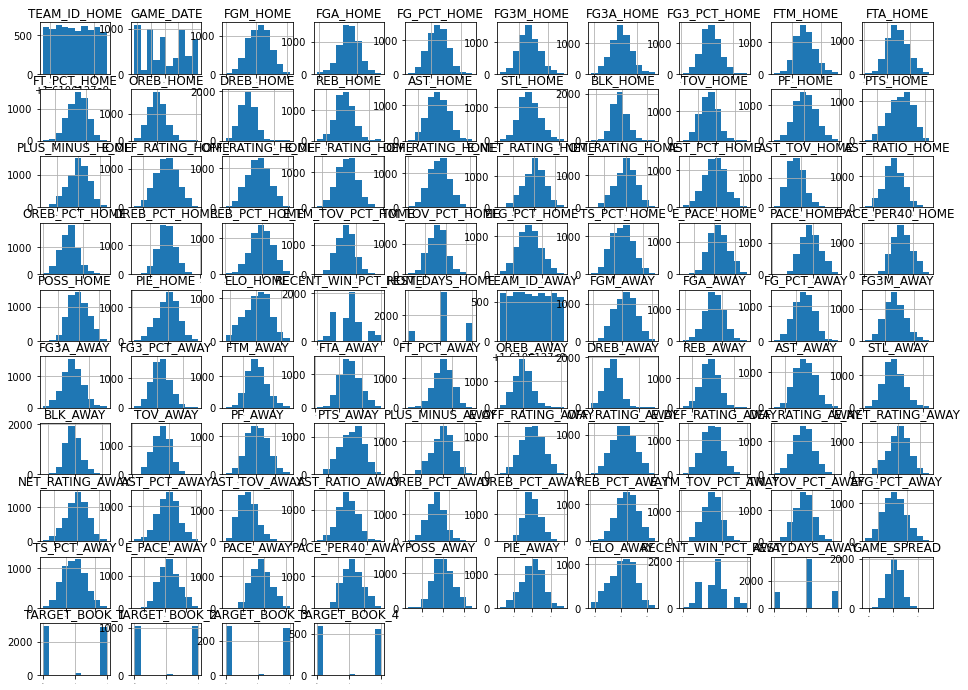

In [42]:
#check distribution of data
final_df.hist(figsize=(16,12), xlabelsize=0)

In [44]:
check_missing_vals(final_df)

['SPREAD_2_AWAY',
 'SPREAD_3_AWAY',
 'SPREAD_4_AWAY',
 'SPREAD_2_HOME',
 'SPREAD_3_HOME',
 'SPREAD_4_HOME',
 'TARGET_BOOK_2',
 'TARGET_BOOK_3',
 'TARGET_BOOK_4']

In [45]:
final_df.to_csv('data_book_1.csv')
print('Data converted to csv')
print('Runtime : ', datetime.now() - start_time)

Data converted to csv
Runtime :  1:04:59.854660


TO DO:
- Remove unnecessary columns (including GAME_SREAD and book cols)
- Standardize data
- PCA